# TODOs

- TODO: description

In [1]:
import numpy as np
import torch
import gpytorch
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021())
figheight = bundles.neurips2021()["figure.figsize"][1]
figwidth = bundles.neurips2021()["figure.figsize"][0]
print(figheight, figwidth)

1.699593426303529 5.499999861629998


In [3]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import classification_utils
import classification_models

In [ ]:
seed = 5 #1,2,3,4,5
np.random.seed(seed)
torch.manual_seed(seed)

# Load all datasets

The four datasets we use are 
- EEG
- HTRU2
- MAGIC
- MiniBoo
All of them are UCI datasets that were already used for the Dirichlet GPC paper

In [4]:
### load EEG dataset
data_files = "data/"

EEG_filename = "EEG_Eye_State.csv"
EEG_df = pd.read_csv(data_files + EEG_filename, header=None)
EEG_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [5]:
### load HTRU2 dataset
HTRU2_filename = "HTRU_2.csv"
HTRU2_df = pd.read_csv(data_files + HTRU2_filename, header=None)
HTRU2_df.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [6]:
### load MAGIC dataset
MAGIC_filename = "magic04.csv"
MAGIC_df = pd.read_csv(data_files + MAGIC_filename, header=None)

#map final column from g/h to 1/0
MAGIC_df = MAGIC_df.replace({"g":1, "h":0})

MAGIC_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [7]:
### load Miniboo dataset
train_dfs = []
test_dfs = []

# IMPORTANT: there are 10 splits for train and test. Each of them has 120K training points ... 
# However, the k-means clustering algorithm may take a while if we load all of them
# Therefore, it might make more sense to just choose 1 split for the beginning.
for i in range(1): #10
    i_ = i+1
    # load training
    MiniBoo_filename_train = "MiniBoo_splits/train{:02d}.txt".format(i_)
    MiniBoo_df_train = pd.read_csv(data_files + MiniBoo_filename_train, header=None)
    train_dfs.append(MiniBoo_df_train)
    # load test
    MiniBoo_filename_test = "MiniBoo_splits/test{:02d}.txt".format(i_)
    MiniBoo_df_test = pd.read_csv(data_files + MiniBoo_filename_test, header=None)
    test_dfs.append(MiniBoo_df_test)
    
MiniBoo_train_df = pd.concat(train_dfs)
MiniBoo_test_df = pd.concat(test_dfs)
MiniBoo_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,3.96113,0.384599,1087.1200,0.251748,0.015258,0.000000,1.116820,0.872463,3.11779,0.185689,...,-19.7970,0.947933,2.29170,0.000000,0.242451,0.184653,2.975180,0.016929,0.236594,0.0
1,3.84353,1.741840,101.6440,0.295625,0.002525,0.130203,1.171860,0.885831,3.40604,0.207060,...,-32.3280,3.938770,6.63478,0.002525,0.160161,0.220539,0.792976,0.056713,0.198655,1.0
2,6.88238,2.748180,88.5783,0.300086,0.002597,0.000000,0.737055,0.677884,3.89686,0.093560,...,-88.3881,-0.793292,3.08822,0.000000,0.124882,0.367171,6.016120,6.133560,0.255304,1.0
3,3.43173,1.948110,103.1530,0.264039,0.000000,0.191277,1.177080,0.883820,3.27063,0.169655,...,-24.1426,0.435008,4.61928,0.000000,0.127263,0.172886,0.985063,0.212094,0.203885,1.0
4,2.75619,0.405642,63.6347,0.233746,0.011423,0.406455,1.089350,0.883967,3.29230,0.207975,...,-21.1712,0.097014,4.57457,0.001038,0.129168,-0.085241,0.886991,-0.020713,0.273904,0.0


## Normalize & Create test train splits

As in the Dirichlet GPC paper, we use the following test-train splits
TODO

In [8]:
# make test-train split for EEG
from sklearn.model_selection import train_test_split

X_EEG = EEG_df.values[:,:-1]
Y_EEG = EEG_df.values[:,-1]
NUM_TRAINING_POINTS_EEG=10980
NUM_TEST_POINTS_EEG=4000

# Normalize data
X_EEG = classification_utils.standardise(X_EEG)
#X_EEG = classification_utils.normalise_minusonetoone(X_EEG)

# The original paper chose 10980 training points and 4000 test points
test_size_EEG = NUM_TEST_POINTS_EEG/(NUM_TRAINING_POINTS_EEG+NUM_TEST_POINTS_EEG)
X_EEG_train, X_EEG_test, y_EEG_train, y_EEG_test = train_test_split(X_EEG, Y_EEG, test_size=test_size_EEG, random_state=seed)
print(np.shape(X_EEG_train))
print(np.shape(X_EEG_test))
print(np.shape(y_EEG_train))
print(np.shape(y_EEG_test))
X_EEG_train, X_EEG_test, y_EEG_train, y_EEG_test = torch.tensor(X_EEG_train).float(), torch.tensor(X_EEG_test).float(), \
                                                   torch.tensor(y_EEG_train).long(), torch.tensor(y_EEG_test).long()
print(y_EEG_test[:20])

(10980, 14)
(4000, 14)
(10980,)
(4000,)
tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0])


In [9]:
# make test-train split for HTRU2

X_HTRU2 = HTRU2_df.values[:,:-1]
Y_HTRU2 = HTRU2_df.values[:,-1]
NUM_TRAINING_POINTS_HTRU2=12898
NUM_TEST_POINTS_HTRU2=5000

# Normalize data
X_HTRU2 = classification_utils.standardise(X_HTRU2)
#X_HTRU2 = classification_utils.normalise_minusonetoone(X_HTRU2)

test_size_HTRU2 = NUM_TEST_POINTS_HTRU2/(NUM_TRAINING_POINTS_HTRU2+NUM_TEST_POINTS_HTRU2)
X_HTRU2_train, X_HTRU2_test, y_HTRU2_train, y_HTRU2_test = train_test_split(X_HTRU2, Y_HTRU2, test_size=test_size_HTRU2, random_state=seed)
print(np.shape(X_HTRU2_train))
print(np.shape(X_HTRU2_test))
print(np.shape(y_HTRU2_train))
print(np.shape(y_HTRU2_test))
X_HTRU2_train, X_HTRU2_test, y_HTRU2_train, y_HTRU2_test = torch.tensor(X_HTRU2_train).float(), torch.tensor(X_HTRU2_test).float(), \
                                                   torch.tensor(y_HTRU2_train).long(), torch.tensor(y_HTRU2_test).long()
print(y_HTRU2_test[:20])

(12898, 8)
(5000, 8)
(12898,)
(5000,)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
# make test-train split for MAGIC

X_MAGIC = MAGIC_df.values[:,:-1]
Y_MAGIC = MAGIC_df.values[:,-1]
NUM_TRAINING_POINTS_MAGIC=14020
NUM_TEST_POINTS_MAGIC=5000

# Normalize data
X_MAGIC = classification_utils.standardise(X_MAGIC)
#X_MAGIC = classification_utils.normalise_minusonetoone(X_MAGIC)

test_size_MAGIC = NUM_TEST_POINTS_MAGIC/(NUM_TRAINING_POINTS_MAGIC+NUM_TEST_POINTS_MAGIC)
X_MAGIC_train, X_MAGIC_test, y_MAGIC_train, y_MAGIC_test = train_test_split(X_MAGIC, Y_MAGIC, test_size=test_size_MAGIC, random_state=seed)
print(np.shape(X_MAGIC_train))
print(np.shape(X_MAGIC_test))
print(np.shape(y_MAGIC_train))
print(np.shape(y_MAGIC_test))
X_MAGIC_train, X_MAGIC_test, y_MAGIC_train, y_MAGIC_test = torch.tensor(X_MAGIC_train).float(), torch.tensor(X_MAGIC_test).float(), \
                                                   torch.tensor(y_MAGIC_train).long(), torch.tensor(y_MAGIC_test).long()
print(y_MAGIC_test[:20])

(14020, 10)
(5000, 10)
(14020,)
(5000,)
tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0])


In [11]:
# make test-train split for MiniBoo

X_MiniBoo_train = MiniBoo_train_df.values[:,:-1]
y_MiniBoo_train = MiniBoo_train_df.values[:,-1]
X_MiniBoo_test = MiniBoo_test_df.values[:,:-1]
y_MiniBoo_test = MiniBoo_test_df.values[:,-1]

# IMPORTANT: the miniboo dataset is kinda large (120K datapoints)
# Therefore, we'll prune it when testing the code.
X_MiniBoo_train = X_MiniBoo_train[:20000,:]
y_MiniBoo_train = y_MiniBoo_train[:20000]
X_MiniBoo_test = X_MiniBoo_test[:5000,:]
y_MiniBoo_test = y_MiniBoo_test[:5000]

# Normalize data
X_MiniBoo_train = classification_utils.standardise(X_MiniBoo_train)
X_MiniBoo_test = classification_utils.standardise(X_MiniBoo_test)
#X_MiniBoo = classification_utils.normalise_minusonetoone(X_MiniBoo)

print(np.shape(X_MiniBoo_train))
print(np.shape(X_MiniBoo_test))
print(np.shape(y_MiniBoo_train))
print(np.shape(y_MiniBoo_test))
X_MiniBoo_train, X_MiniBoo_test, y_MiniBoo_train, y_MiniBoo_test = torch.tensor(X_MiniBoo_train).float(), torch.tensor(X_MiniBoo_test).float(), \
                                                   torch.tensor(y_MiniBoo_train).long(), torch.tensor(y_MiniBoo_test).long()
print(y_MiniBoo_test[:20])

(20000, 50)
(5000, 50)
(20000,)
(5000,)
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])


## Create inducing points

As in the Dirichlet GPC paper, we use the following number of inducing points
TODO

In [12]:
NUM_INDUCING_POINTS_EEG=200
NUM_INDUCING_POINTS_HTRU2=200
NUM_INDUCING_POINTS_MAGIC=200
NUM_INDUCING_POINTS_MiniBoo=400

In [13]:
### EEG

## choose random inducing points
#X_EEG_train_induced, y_EEG_train_induced = classification_utils.random_inducing_points(X_EEG_train, y_EEG_train, NUM_INDUCING_POINTS_EEG)

## use kmeans for inducing points
X_EEG_train_induced, y_EEG_train_induced = classification_utils.k_means_inducing_points(X_EEG_train, y_EEG_train, NUM_INDUCING_POINTS_EEG)
print(X_EEG_train_induced[:2], y_EEG_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_EEG_train_induced, y_EEG_train_induced_alphas, y_EEG_train_induced_betas = classification_utils.k_means_inducing_points_LM_beta(X_EEG_train, y_EEG_train, NUM_INDUCING_POINTS_EEG)
print(X_EEG_train_induced[:2], y_EEG_train_induced_alphas[:2], y_EEG_train_induced_betas[:2])

tensor([[ 5.0884e-02,  2.3213e+00,  8.2130e-01,  4.0649e-03,  6.7907e-02,
         -9.0890e-03, -8.8377e-03, -1.0732e+00, -2.1053e-02, -2.1646e-01,
          5.3204e-01,  9.0719e-01,  2.0520e-02,  1.2531e-02],
        [-3.4462e-03, -8.7130e-01, -9.7336e-03, -1.3925e-02, -2.8646e-01,
         -1.5404e-02, -3.4864e-03,  2.9466e-02, -4.4921e-03,  3.8985e-01,
          1.1159e+00,  5.6152e-01,  4.4710e-02,  2.5703e-04]]) tensor([0, 1])
tensor([[ 5.0884e-02,  2.3213e+00,  8.2130e-01,  4.0649e-03,  6.7907e-02,
         -9.0890e-03, -8.8377e-03, -1.0732e+00, -2.1053e-02, -2.1646e-01,
          5.3204e-01,  9.0719e-01,  2.0520e-02,  1.2531e-02],
        [-3.4462e-03, -8.7130e-01, -9.7336e-03, -1.3925e-02, -2.8646e-01,
         -1.5404e-02, -3.4864e-03,  2.9466e-02, -4.4921e-03,  3.8985e-01,
          1.1159e+00,  5.6152e-01,  4.4710e-02,  2.5703e-04]]) tensor([12.0100, 36.0100]) tensor([18.0100,  2.0100])


In [14]:
### HTRU2

## choose random inducing points
#X_HTRU2_train_induced, y_HTRU2_train_induced = classification_utils.random_inducing_points(X_HTRU2_train, y_HTRU2_train, NUM_INDUCING_POINTS_HTRU2)

## use kmeans for inducing points
X_HTRU2_train_induced, y_HTRU2_train_induced = classification_utils.k_means_inducing_points(X_HTRU2_train, y_HTRU2_train, NUM_INDUCING_POINTS_HTRU2)
print(X_HTRU2_train_induced[:2], y_HTRU2_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_HTRU2_train_induced, y_HTRU2_train_induced_alphas, y_HTRU2_train_induced_betas = classification_utils.k_means_inducing_points_LM_beta(X_HTRU2_train, y_HTRU2_train, NUM_INDUCING_POINTS_HTRU2)
print(X_HTRU2_train_induced[:2], y_HTRU2_train_induced_alphas[:2], y_HTRU2_train_induced_betas[:2])

tensor([[ 0.3313,  1.4238, -0.2694, -0.3310, -0.3440, -0.4739,  0.2409, -0.0279],
        [-2.1703, -0.7639,  2.2148,  1.1235,  3.4244,  2.6550, -1.8571, -0.9940]]) tensor([0, 1])
tensor([[ 0.3313,  1.4238, -0.2694, -0.3310, -0.3440, -0.4739,  0.2409, -0.0279],
        [-2.1703, -0.7639,  2.2148,  1.1235,  3.4244,  2.6550, -1.8571, -0.9940]]) tensor([ 2.0100, 16.0100]) tensor([126.0100,   2.0100])


In [15]:
### MAGIC

## choose random inducing points
#X_MAGIC_train_induced, y_MAGIC_train_induced = classification_utils.random_inducing_points(X_MAGIC_train, y_MAGIC_train, NUM_INDUCING_POINTS_MAGIC)

## use kmeans for inducing points
X_MAGIC_train_induced, y_MAGIC_train_induced = classification_utils.k_means_inducing_points(X_MAGIC_train, y_MAGIC_train, NUM_INDUCING_POINTS_MAGIC)
print(X_MAGIC_train_induced[:2], y_MAGIC_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_MAGIC_train_induced, y_MAGIC_train_induced_alphas, y_MAGIC_train_induced_betas = classification_utils.k_means_inducing_points_LM_beta(X_MAGIC_train, y_MAGIC_train, NUM_INDUCING_POINTS_MAGIC)
print(X_MAGIC_train_induced[:2], y_MAGIC_train_induced_alphas[:2], y_MAGIC_train_induced_betas[:2])

tensor([[-0.7744, -0.8129, -1.6624,  1.8160,  1.4872,  0.0502, -0.0455, -0.2872,
         -0.6087, -0.8407],
        [-0.2652, -0.3498,  0.1991, -0.5122, -0.6394,  0.3475,  0.3502, -0.5967,
         -1.0236,  0.0660]]) tensor([1, 1])
tensor([[-0.7744, -0.8129, -1.6624,  1.8160,  1.4872,  0.0502, -0.0455, -0.2872,
         -0.6087, -0.8407],
        [-0.2652, -0.3498,  0.1991, -0.5122, -0.6394,  0.3475,  0.3502, -0.5967,
         -1.0236,  0.0660]]) tensor([116.0100, 190.0100]) tensor([23.0100,  9.0100])


In [16]:
### MiniBoo

## choose random inducing points
#X_MiniBoo_train_induced, y_MiniBoo_train_induced = classification_utils.random_inducing_points(X_MiniBoo_train, y_MiniBoo_train, NUM_INDUCING_POINTS_MiniBoo)

## use kmeans for inducing points
X_MiniBoo_train_induced, y_MiniBoo_train_induced = classification_utils.k_means_inducing_points(X_MiniBoo_train, y_MiniBoo_train, NUM_INDUCING_POINTS_MiniBoo)
print(X_MiniBoo_train_induced[:2], y_MiniBoo_train_induced[:2])

# use the conjugacy of the Beta to create better inducing points
X_MiniBoo_train_induced, y_MiniBoo_train_induced_alphas, y_MiniBoo_train_induced_betas = classification_utils.k_means_inducing_points_LM_beta(X_MiniBoo_train, y_MiniBoo_train, NUM_INDUCING_POINTS_MiniBoo)
print(X_MiniBoo_train_induced[:2], y_MiniBoo_train_induced_alphas[:2], y_MiniBoo_train_induced_betas[:2])

tensor([[ 5.3033e-02,  5.3380e-02, -1.3805e-02,  6.1487e-02,  6.2018e-02,
          6.1813e-02,  6.2235e-02,  6.3347e-02,  5.6586e-02,  6.1945e-02,
          5.7336e-02, -9.7243e-01,  6.7089e-02,  5.7450e-02,  7.2649e-02,
          2.0188e-01,  6.3359e-02, -5.2585e-02,  6.1781e-02,  3.9299e-02,
          7.9400e-02,  6.3935e-02,  5.9228e-01,  5.0811e-02,  6.2558e-02,
          8.1421e-02,  7.4281e-01,  6.1410e-02,  6.1776e-02,  6.3557e-02,
          3.8173e-02,  6.5781e-02,  5.8706e-02,  9.4155e-01,  6.2700e-02,
          6.0825e-02,  5.7044e-02,  6.0110e-02,  6.4846e-02,  6.2386e-02,
         -1.0134e-01,  4.8157e-01,  6.4993e-02,  7.1605e-03,  6.2020e-02,
          6.2424e-02,  6.9011e-02,  4.6987e-02,  4.6492e-02,  6.2751e-02],
        [-1.6083e+01, -1.6084e+01, -5.3979e+00, -1.6085e+01, -1.6085e+01,
         -1.6085e+01, -1.6085e+01, -1.6085e+01, -1.6085e+01, -1.6085e+01,
         -1.6085e+01, -8.5687e+00, -1.6085e+01, -1.6085e+01, -1.6084e+01,
         -2.9299e+00, -1.6085e+01, -1

# Setup for GPC & LB(Beta)+GP

In [17]:
LENGTHSCALES = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]

## EEG

In [18]:
### choose lengthscale with CV
NUM_ITER_EEG = 200
LR_EEG = 0.1
"""
res_EEG = classification_models.select_init_lengthscale_with_CV(X_EEG_train, y_EEG_train, mode="DGP",
                                    num_inducing_points=NUM_INDUCING_POINTS_EEG, 
                                    learn_noise=True, num_iter=NUM_ITER_EEG, lr=LR_EEG,
                                    lengthscales=LENGTHSCALES)
print(res_EEG)    
classification_utils.plot_res(res_EEG)
"""

INIT_LENGHTSCALE_EEG = 2

In [19]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_EEG_train_induced, y_EEG_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_EEG, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_EEG_train_induced,
                                DGP_model, DGP_likelihood, num_iter=NUM_ITER_EEG, lr=LR_EEG, report_iter=NUM_ITER_EEG//10)
EEG_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_EEG_test, y_EEG_test)
print(EEG_DGP_res)

Iter 1/200 - Loss: 5.967   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 5.355   lengthscale: 1.102   noise: 2.084
Iter 41/200 - Loss: 5.152   lengthscale: 0.907   noise: 3.340
Iter 61/200 - Loss: 5.130   lengthscale: 0.989   noise: 3.917
Iter 81/200 - Loss: 5.127   lengthscale: 1.017   noise: 4.145
Iter 101/200 - Loss: 5.127   lengthscale: 1.037   noise: 4.224
Iter 121/200 - Loss: 5.126   lengthscale: 1.048   noise: 4.244
Iter 141/200 - Loss: 5.126   lengthscale: 1.052   noise: 4.241
Iter 161/200 - Loss: 5.126   lengthscale: 1.056   noise: 4.228
Iter 181/200 - Loss: 5.126   lengthscale: 1.059   noise: 4.212
(0.6467499732971191, 0.7012051939964294, 0.12777778506278992)


In [20]:
### Run LM(Beta)+GP vanilla
y_EEG_train_induced_mu, y_EEG_train_induced_var = classification_models.transform_y_beta_LM(y_EEG_train_induced)
LMGP_model_EEG, LMGP_likelihood_EEG = classification_models.create_LM_beta_GP_model(X_EEG_train_induced, y_EEG_train_induced_mu,
                                                y_EEG_train_induced_var, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_EEG)
LMGP_model_EEG, LMGP_likelihood_EEG = classification_models.train_LM_beta_GP_model(X_EEG_train_induced, y_EEG_train_induced_mu,
                    LMGP_model_EEG, LMGP_likelihood_EEG, num_iter=NUM_ITER_EEG, lr=LR_EEG, report_iter=NUM_ITER_EEG//10)
EEG_LMGP_res = classification_models.evaluate_LM_beta_GP(LMGP_model_EEG, LMGP_likelihood_EEG, X_EEG_test, y_EEG_test)
print(EEG_LMGP_res)

Iter 1/200 - Loss: 3.040   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.966   lengthscale: 1.035   noise: 2.124
Iter 41/200 - Loss: 2.933   lengthscale: 1.307   noise: 3.780
Iter 61/200 - Loss: 2.921   lengthscale: 1.448   noise: 5.039
Iter 81/200 - Loss: 2.917   lengthscale: 1.507   noise: 5.896
Iter 101/200 - Loss: 2.915   lengthscale: 1.562   noise: 6.477
Iter 121/200 - Loss: 2.914   lengthscale: 1.605   noise: 6.876
Iter 141/200 - Loss: 2.913   lengthscale: 1.639   noise: 7.149
Iter 161/200 - Loss: 2.913   lengthscale: 1.665   noise: 7.332
Iter 181/200 - Loss: 2.913   lengthscale: 1.685   noise: 7.451
(0.606249988079071, 0.7131885290145874, 0.14380775392055511)


In [21]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_EEG, train_var_LB_con_EEG = classification_models.LM_beta(y_EEG_train_induced_alphas, y_EEG_train_induced_betas)
LMGP_model_con_EEG, LMGP_likelihood_con_EEG = classification_models.create_LM_beta_GP_model(X_EEG_train_induced, train_mu_LB_con_EEG,
                                                train_var_LB_con_EEG, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_EEG)
LMGP_model_con_EEG, LMGP_likelihood_con_EEG = classification_models.train_LM_beta_GP_model(X_EEG_train_induced, train_mu_LB_con_EEG,
                LMGP_model_con_EEG, LMGP_likelihood_con_EEG, num_iter=NUM_ITER_EEG, lr=LR_EEG, report_iter=NUM_ITER_EEG//10)

EEG_LMGP_con_res = classification_models.evaluate_LM_beta_GP(LMGP_model_con_EEG, LMGP_likelihood_con_EEG, X_EEG_test, y_EEG_test)
print(EEG_LMGP_con_res)

Iter 1/200 - Loss: 2.350   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.278   lengthscale: 1.174   noise: 1.206
Iter 41/200 - Loss: 2.211   lengthscale: 0.792   noise: 0.435
Iter 61/200 - Loss: 2.179   lengthscale: 0.729   noise: 0.131
Iter 81/200 - Loss: 2.169   lengthscale: 0.730   noise: 0.083
Iter 101/200 - Loss: 2.164   lengthscale: 0.748   noise: 0.071
Iter 121/200 - Loss: 2.161   lengthscale: 0.760   noise: 0.066
Iter 141/200 - Loss: 2.159   lengthscale: 0.771   noise: 0.064
Iter 161/200 - Loss: 2.158   lengthscale: 0.781   noise: 0.063
Iter 181/200 - Loss: 2.157   lengthscale: 0.789   noise: 0.063
(0.7127500176429749, 0.5398080348968506, 0.021660421043634415)


## HTRU2

In [22]:
### choose lengthscale with CV
NUM_ITER_HTRU2 = 200
LR_HTRU2 = 0.1
"""
res_HTRU2 = classification_models.select_init_lengthscale_with_CV(X_HTRU2_train, y_HTRU2_train, mode="DGP",
                                    num_inducing_points=NUM_INDUCING_POINTS_HTRU2, 
                                    learn_noise=True, num_iter=NUM_ITER_HTRU2, lr=LR_HTRU2,
                                    lengthscales=LENGTHSCALES)
print(res_HTRU2)    
classification_utils.plot_res(res_HTRU2)
"""

INIT_LENGHTSCALE_HTRU2 = 2

In [23]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_HTRU2_train_induced, y_HTRU2_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_HTRU2, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_HTRU2_train_induced,
                                DGP_model, DGP_likelihood, num_iter=NUM_ITER_HTRU2, lr=LR_HTRU2, report_iter=NUM_ITER_HTRU2//10)
HTRU2_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_HTRU2_test, y_HTRU2_test)
print(HTRU2_DGP_res)

Iter 1/200 - Loss: 4.444   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 3.501   lengthscale: 3.426   noise: 0.159
Iter 41/200 - Loss: 3.397   lengthscale: 3.851   noise: 0.115
Iter 61/200 - Loss: 3.368   lengthscale: 3.877   noise: 0.091
Iter 81/200 - Loss: 3.356   lengthscale: 3.854   noise: 0.055
Iter 101/200 - Loss: 3.349   lengthscale: 3.871   noise: 0.039
Iter 121/200 - Loss: 3.345   lengthscale: 3.922   noise: 0.031
Iter 141/200 - Loss: 3.343   lengthscale: 3.976   noise: 0.027
Iter 161/200 - Loss: 3.341   lengthscale: 4.021   noise: 0.024
Iter 181/200 - Loss: 3.339   lengthscale: 4.061   noise: 0.022
(0.9782000184059143, 0.07795679569244385, 0.03839163854718208)


In [24]:
### Run LM(Beta)+GP vanilla
y_HTRU2_train_induced_mu, y_HTRU2_train_induced_var = classification_models.transform_y_beta_LM(y_HTRU2_train_induced)
LMGP_model_HTRU2, LMGP_likelihood_HTRU2 = classification_models.create_LM_beta_GP_model(X_HTRU2_train_induced, y_HTRU2_train_induced_mu,
                                                y_HTRU2_train_induced_var, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_HTRU2)
LMGP_model_HTRU2, LMGP_likelihood_HTRU2 = classification_models.train_LM_beta_GP_model(X_HTRU2_train_induced, y_HTRU2_train_induced_mu,
                    LMGP_model_HTRU2, LMGP_likelihood_HTRU2, num_iter=NUM_ITER_HTRU2, lr=LR_HTRU2, report_iter=NUM_ITER_HTRU2//10)
HTRU2_LMGP_res = classification_models.evaluate_LM_beta_GP(LMGP_model_HTRU2, LMGP_likelihood_HTRU2, X_HTRU2_test, y_HTRU2_test)
print(HTRU2_LMGP_res)

Iter 1/200 - Loss: 2.599   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.381   lengthscale: 3.525   noise: 0.137
Iter 41/200 - Loss: 2.347   lengthscale: 4.105   noise: 0.042
Iter 61/200 - Loss: 2.336   lengthscale: 4.172   noise: 0.022
Iter 81/200 - Loss: 2.330   lengthscale: 4.140   noise: 0.015
Iter 101/200 - Loss: 2.326   lengthscale: 4.136   noise: 0.012
Iter 121/200 - Loss: 2.324   lengthscale: 4.165   noise: 0.009
Iter 141/200 - Loss: 2.322   lengthscale: 4.205   noise: 0.008
Iter 161/200 - Loss: 2.321   lengthscale: 4.244   noise: 0.006
Iter 181/200 - Loss: 2.319   lengthscale: 4.280   noise: 0.005
(0.9768000245094299, 0.0793921947479248, 0.039690300822257996)


In [25]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_HTRU2, train_var_LB_con_HTRU2 = classification_models.LM_beta(y_HTRU2_train_induced_alphas, y_HTRU2_train_induced_betas)
LMGP_model_con_HTRU2, LMGP_likelihood_con_HTRU2 = classification_models.create_LM_beta_GP_model(X_HTRU2_train_induced, train_mu_LB_con_HTRU2,
                                                train_var_LB_con_HTRU2, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_HTRU2)
LMGP_model_con_HTRU2, LMGP_likelihood_con_HTRU2 = classification_models.train_LM_beta_GP_model(X_HTRU2_train_induced, train_mu_LB_con_HTRU2,
                LMGP_model_con_HTRU2, LMGP_likelihood_con_HTRU2, num_iter=NUM_ITER_HTRU2, lr=LR_HTRU2, report_iter=NUM_ITER_HTRU2//10)

HTRU2_LMGP_con_res = classification_models.evaluate_LM_beta_GP(LMGP_model_con_HTRU2, LMGP_likelihood_con_HTRU2, X_HTRU2_test, y_HTRU2_test)
print(HTRU2_LMGP_con_res)

Iter 1/200 - Loss: 2.620   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.252   lengthscale: 3.407   noise: 0.161
Iter 41/200 - Loss: 2.191   lengthscale: 3.578   noise: 0.088
Iter 61/200 - Loss: 2.163   lengthscale: 3.290   noise: 0.066
Iter 81/200 - Loss: 2.149   lengthscale: 3.210   noise: 0.045
Iter 101/200 - Loss: 2.139   lengthscale: 3.267   noise: 0.032
Iter 121/200 - Loss: 2.132   lengthscale: 3.289   noise: 0.024
Iter 141/200 - Loss: 2.127   lengthscale: 3.308   noise: 0.019
Iter 161/200 - Loss: 2.123   lengthscale: 3.335   noise: 0.016
Iter 181/200 - Loss: 2.119   lengthscale: 3.358   noise: 0.013
(0.9796000123023987, 0.07123546302318573, 0.04246756061911583)


## MAGIC

In [26]:
### choose lengthscale with CV
NUM_ITER_MAGIC = 200
LR_MAGIC = 0.1
"""
res_MAGIC = classification_models.select_init_lengthscale_with_CV(X_MAGIC_train, y_MAGIC_train, mode="DGP",
                                    num_inducing_points=NUM_INDUCING_POINTS_MAGIC, 
                                    learn_noise=True, num_iter=NUM_ITER_MAGIC, lr=LR_MAGIC,
                                    lengthscales=LENGTHSCALES)
print(res_MAGIC)    
classification_utils.plot_res(res_MAGIC)
"""

INIT_LENGHTSCALE_MAGIC = 2

In [27]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_MAGIC_train_induced, y_MAGIC_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_MAGIC, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_MAGIC_train_induced,
                                DGP_model, DGP_likelihood, num_iter=NUM_ITER_MAGIC, lr=LR_MAGIC, report_iter=NUM_ITER_MAGIC//10)
MAGIC_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_MAGIC_test, y_MAGIC_test)
print(MAGIC_DGP_res)

Iter 1/200 - Loss: 5.675   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 4.719   lengthscale: 3.013   noise: 1.796
Iter 41/200 - Loss: 4.619   lengthscale: 3.311   noise: 1.784
Iter 61/200 - Loss: 4.587   lengthscale: 3.351   noise: 1.436
Iter 81/200 - Loss: 4.569   lengthscale: 3.196   noise: 1.342
Iter 101/200 - Loss: 4.555   lengthscale: 3.070   noise: 1.307
Iter 121/200 - Loss: 4.545   lengthscale: 2.936   noise: 1.245
Iter 141/200 - Loss: 4.538   lengthscale: 2.823   noise: 1.188
Iter 161/200 - Loss: 4.533   lengthscale: 2.735   noise: 1.152
Iter 181/200 - Loss: 4.531   lengthscale: 2.687   noise: 1.131
(0.795799970626831, 0.5362366437911987, 0.10130868852138519)


In [28]:
### Run LM(Beta)+GP vanilla
y_MAGIC_train_induced_mu, y_MAGIC_train_induced_var = classification_models.transform_y_beta_LM(y_MAGIC_train_induced)
LMGP_model_MAGIC, LMGP_likelihood_MAGIC = classification_models.create_LM_beta_GP_model(X_MAGIC_train_induced, y_MAGIC_train_induced_mu,
                                                y_MAGIC_train_induced_var, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_MAGIC)
LMGP_model_MAGIC, LMGP_likelihood_MAGIC = classification_models.train_LM_beta_GP_model(X_MAGIC_train_induced, y_MAGIC_train_induced_mu,
                    LMGP_model_MAGIC, LMGP_likelihood_MAGIC, num_iter=NUM_ITER_MAGIC, lr=LR_MAGIC, report_iter=NUM_ITER_MAGIC//10)
MAGIC_LMGP_res = classification_models.evaluate_LM_beta_GP(LMGP_model_MAGIC, LMGP_likelihood_MAGIC, X_MAGIC_test, y_MAGIC_test)
print(MAGIC_LMGP_res)

Iter 1/200 - Loss: 2.925   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.733   lengthscale: 3.253   noise: 1.609
Iter 41/200 - Loss: 2.684   lengthscale: 2.736   noise: 0.876
Iter 61/200 - Loss: 2.667   lengthscale: 2.743   noise: 0.263
Iter 81/200 - Loss: 2.659   lengthscale: 2.752   noise: 0.116
Iter 101/200 - Loss: 2.656   lengthscale: 2.794   noise: 0.072
Iter 121/200 - Loss: 2.653   lengthscale: 2.815   noise: 0.052
Iter 141/200 - Loss: 2.652   lengthscale: 2.845   noise: 0.040
Iter 161/200 - Loss: 2.651   lengthscale: 2.869   noise: 0.032
Iter 181/200 - Loss: 2.650   lengthscale: 2.891   noise: 0.026
(0.7932000160217285, 0.49166595935821533, 0.08232767879962921)


In [29]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_MAGIC, train_var_LB_con_MAGIC = classification_models.LM_beta(y_MAGIC_train_induced_alphas, y_MAGIC_train_induced_betas)
LMGP_model_con_MAGIC, LMGP_likelihood_con_MAGIC = classification_models.create_LM_beta_GP_model(X_MAGIC_train_induced, train_mu_LB_con_MAGIC,
                                                train_var_LB_con_MAGIC, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_MAGIC)
LMGP_model_con_MAGIC, LMGP_likelihood_con_MAGIC = classification_models.train_LM_beta_GP_model(X_MAGIC_train_induced, train_mu_LB_con_MAGIC,
                LMGP_model_con_MAGIC, LMGP_likelihood_con_MAGIC, num_iter=NUM_ITER_MAGIC, lr=LR_MAGIC, report_iter=NUM_ITER_MAGIC//10)

MAGIC_LMGP_con_res = classification_models.evaluate_LM_beta_GP(LMGP_model_con_MAGIC, LMGP_likelihood_con_MAGIC, X_MAGIC_test, y_MAGIC_test)
print(MAGIC_LMGP_con_res)

Iter 1/200 - Loss: 2.124   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 1.675   lengthscale: 3.445   noise: 0.139
Iter 41/200 - Loss: 1.615   lengthscale: 3.478   noise: 0.048
Iter 61/200 - Loss: 1.602   lengthscale: 3.340   noise: 0.028
Iter 81/200 - Loss: 1.598   lengthscale: 3.473   noise: 0.020
Iter 101/200 - Loss: 1.595   lengthscale: 3.522   noise: 0.016
Iter 121/200 - Loss: 1.593   lengthscale: 3.563   noise: 0.013
Iter 141/200 - Loss: 1.592   lengthscale: 3.608   noise: 0.011
Iter 161/200 - Loss: 1.591   lengthscale: 3.643   noise: 0.009
Iter 181/200 - Loss: 1.591   lengthscale: 3.675   noise: 0.008
(0.8162000179290771, 0.40867048501968384, 0.04362637922167778)


## MiniBoo

In [30]:
### choose lengthscale with CV
NUM_ITER_MiniBoo = 200
LR_MiniBoo = 0.1
"""
res_MiniBoo = classification_models.select_init_lengthscale_with_CV(X_MiniBoo_train, y_MiniBoo_train, mode="DGP",
                                    num_inducing_points=NUM_INDUCING_POINTS_MiniBoo, 
                                    learn_noise=True, num_iter=NUM_ITER_MiniBoo, lr=LR_MiniBoo,
                                    lengthscales=LENGTHSCALES)
print(res_MiniBoo)    
classification_utils.plot_res(res_MiniBoo)
"""

INIT_LENGHTSCALE_MiniBoo = 2

In [31]:
### run Dirichlet GPC

DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_MiniBoo_train_induced, y_MiniBoo_train_induced,
                                        init_lengthscale=INIT_LENGHTSCALE_MiniBoo, learn_additional_noise=True)
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_MiniBoo_train_induced,
                                DGP_model, DGP_likelihood, num_iter=NUM_ITER_MiniBoo, lr=LR_MiniBoo, report_iter=NUM_ITER_MiniBoo//10)
MiniBoo_DGP_res = classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_MiniBoo_test, y_MiniBoo_test)
print(MiniBoo_DGP_res)

Iter 1/200 - Loss: 4.973   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 4.445   lengthscale: 2.704   noise: 1.299
Iter 41/200 - Loss: 4.388   lengthscale: 2.939   noise: 0.970
Iter 61/200 - Loss: 4.370   lengthscale: 2.887   noise: 0.978
Iter 81/200 - Loss: 4.356   lengthscale: 2.688   noise: 0.887
Iter 101/200 - Loss: 4.333   lengthscale: 2.338   noise: 0.727
Iter 121/200 - Loss: 4.309   lengthscale: 1.943   noise: 0.611
Iter 141/200 - Loss: 4.305   lengthscale: 1.931   noise: 0.595
Iter 161/200 - Loss: 4.303   lengthscale: 1.973   noise: 0.591
Iter 181/200 - Loss: 4.302   lengthscale: 1.964   noise: 0.590
(0.866599977016449, 0.33838561177253723, 0.029760224744677544)


In [32]:
### Run LM(Beta)+GP vanilla
y_MiniBoo_train_induced_mu, y_MiniBoo_train_induced_var = classification_models.transform_y_beta_LM(y_MiniBoo_train_induced)
LMGP_model_MiniBoo, LMGP_likelihood_MiniBoo = classification_models.create_LM_beta_GP_model(X_MiniBoo_train_induced, y_MiniBoo_train_induced_mu,
                                                y_MiniBoo_train_induced_var, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_MiniBoo)
LMGP_model_MiniBoo, LMGP_likelihood_MiniBoo = classification_models.train_LM_beta_GP_model(X_MiniBoo_train_induced, y_MiniBoo_train_induced_mu,
                    LMGP_model_MiniBoo, LMGP_likelihood_MiniBoo, num_iter=NUM_ITER_MiniBoo, lr=LR_MiniBoo, report_iter=NUM_ITER_MiniBoo//10)
MiniBoo_LMGP_res = classification_models.evaluate_LM_beta_GP(LMGP_model_MiniBoo, LMGP_likelihood_MiniBoo, X_MiniBoo_test, y_MiniBoo_test)
print(MiniBoo_LMGP_res)

Iter 1/200 - Loss: 2.755   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 2.610   lengthscale: 2.559   noise: 0.278
Iter 41/200 - Loss: 2.579   lengthscale: 2.291   noise: 0.058
Iter 61/200 - Loss: 2.571   lengthscale: 2.344   noise: 0.025
Iter 81/200 - Loss: 2.567   lengthscale: 2.389   noise: 0.016
Iter 101/200 - Loss: 2.564   lengthscale: 2.391   noise: 0.012
Iter 121/200 - Loss: 2.563   lengthscale: 2.409   noise: 0.009
Iter 141/200 - Loss: 2.562   lengthscale: 2.427   noise: 0.007
Iter 161/200 - Loss: 2.561   lengthscale: 2.441   noise: 0.006
Iter 181/200 - Loss: 2.561   lengthscale: 2.455   noise: 0.005
(0.8677999973297119, 0.3311293423175812, 0.012597399763762951)


In [33]:
### Run LM(Beta)+GP with conjugacy information

train_mu_LB_con_MiniBoo, train_var_LB_con_MiniBoo = classification_models.LM_beta(y_MiniBoo_train_induced_alphas, y_MiniBoo_train_induced_betas)
LMGP_model_con_MiniBoo, LMGP_likelihood_con_MiniBoo = classification_models.create_LM_beta_GP_model(X_MiniBoo_train_induced, train_mu_LB_con_MiniBoo,
                                                train_var_LB_con_MiniBoo, learn_additional_noise=True,
                                               init_lengthscale=INIT_LENGHTSCALE_MiniBoo)
LMGP_model_con_MiniBoo, LMGP_likelihood_con_MiniBoo = classification_models.train_LM_beta_GP_model(X_MiniBoo_train_induced, train_mu_LB_con_MiniBoo,
                LMGP_model_con_MiniBoo, LMGP_likelihood_con_MiniBoo, num_iter=NUM_ITER_MiniBoo, lr=LR_MiniBoo, report_iter=NUM_ITER_MiniBoo//10)

MiniBoo_LMGP_con_res = classification_models.evaluate_LM_beta_GP(LMGP_model_con_MiniBoo, LMGP_likelihood_con_MiniBoo, X_MiniBoo_test, y_MiniBoo_test)
print(MiniBoo_LMGP_con_res)

Iter 1/200 - Loss: 2.059   lengthscale: 2.000   noise: 0.693
Iter 21/200 - Loss: 1.892   lengthscale: 2.156   noise: 0.162
Iter 41/200 - Loss: 1.870   lengthscale: 2.274   noise: 0.093
Iter 61/200 - Loss: 1.864   lengthscale: 2.337   noise: 0.092
Iter 81/200 - Loss: 1.861   lengthscale: 2.394   noise: 0.098
Iter 101/200 - Loss: 1.860   lengthscale: 2.441   noise: 0.100
Iter 121/200 - Loss: 1.859   lengthscale: 2.470   noise: 0.099
Iter 141/200 - Loss: 1.858   lengthscale: 2.496   noise: 0.098
Iter 161/200 - Loss: 1.858   lengthscale: 2.518   noise: 0.097
Iter 181/200 - Loss: 1.857   lengthscale: 2.536   noise: 0.097
(0.8726000189781189, 0.2973827123641968, 0.02488512359559536)


# save results

In [34]:
all_res = {
    "EEG_res":{
        "DGP":list(EEG_DGP_res), 
        "LMGP":list(EEG_LMGP_res), 
        "LMGP_con":list(EEG_LMGP_con_res)
    },
    "HTRU2_res":{
        "DGP":list(HTRU2_DGP_res), 
        "LMGP":list(HTRU2_LMGP_res), 
        "LMGP_con":list(HTRU2_LMGP_con_res)
    },
    "MAGIC_res":{
        "DGP":list(MAGIC_DGP_res), 
        "LMGP":list(MAGIC_LMGP_res), 
        "LMGP_con":list(MAGIC_LMGP_con_res)
    },
    "MiniBoo_res":{
        "DGP":list(MiniBoo_DGP_res), 
        "LMGP":list(MiniBoo_LMGP_res), 
        "LMGP_con":list(MiniBoo_LMGP_con_res)
    }
}

In [35]:
import json
print(all_res)
#save results for this seed

res_file = open("results/bin_class_seed_{}.json".format(seed), "w")
json.dump(all_res, res_file)
res_file.close()

{'EEG_res': {'DGP': [0.6467499732971191, 0.7012051939964294, 0.12777778506278992], 'LMGP': [0.606249988079071, 0.7131885290145874, 0.14380775392055511], 'LMGP_con': [0.7127500176429749, 0.5398080348968506, 0.021660421043634415]}, 'HTRU2_res': {'DGP': [0.9782000184059143, 0.07795679569244385, 0.03839163854718208], 'LMGP': [0.9768000245094299, 0.0793921947479248, 0.039690300822257996], 'LMGP_con': [0.9796000123023987, 0.07123546302318573, 0.04246756061911583]}, 'MAGIC_res': {'DGP': [0.795799970626831, 0.5362366437911987, 0.10130868852138519], 'LMGP': [0.7932000160217285, 0.49166595935821533, 0.08232767879962921], 'LMGP_con': [0.8162000179290771, 0.40867048501968384, 0.04362637922167778]}, 'MiniBoo_res': {'DGP': [0.866599977016449, 0.33838561177253723, 0.029760224744677544], 'LMGP': [0.8677999973297119, 0.3311293423175812, 0.012597399763762951], 'LMGP_con': [0.8726000189781189, 0.2973827123641968, 0.02488512359559536]}}


In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 1)

# plot results

In [6]:
import json
### over all seeds

DGP_acc_all = []
LMGP_acc_all = []
LMGP_con_acc_all = []
DGP_mnll_all = []
LMGP_mnll_all = []
LMGP_con_mnll_all = []
DGP_ece_all = []
LMGP_ece_all = []
LMGP_con_ece_all = []

for seed in range(5):
    seed +=1

    with open('results/bin_class_seed_{}.json'.format(seed)) as json_file:
        all_res = json.load(json_file)
    print(all_res)

    DGP_acc = []
    LMGP_acc = []
    LMGP_con_acc = []
    DGP_mnll = []
    LMGP_mnll = []
    LMGP_con_mnll = []
    DGP_ece = []
    LMGP_ece = []
    LMGP_con_ece = []

    for dataset in ["EEG_res", "HTRU2_res", "MAGIC_res", "MiniBoo_res"]:

        DGP_acc.append(all_res[dataset]["DGP"][0])
        LMGP_acc.append(all_res[dataset]["LMGP"][0])
        LMGP_con_acc.append(all_res[dataset]["LMGP_con"][0])
        DGP_mnll.append(all_res[dataset]["DGP"][1])
        LMGP_mnll.append(all_res[dataset]["LMGP"][1])
        LMGP_con_mnll.append(all_res[dataset]["LMGP_con"][1])
        DGP_ece.append(all_res[dataset]["DGP"][2])
        LMGP_ece.append(all_res[dataset]["LMGP"][2])
        LMGP_con_ece.append(all_res[dataset]["LMGP_con"][2])
        
    DGP_acc_all.append(DGP_acc)
    LMGP_acc_all.append(LMGP_acc)
    LMGP_con_acc_all.append(LMGP_con_acc)
    DGP_mnll_all.append(DGP_mnll)
    LMGP_mnll_all.append(LMGP_mnll)
    LMGP_con_mnll_all.append(LMGP_con_mnll)
    DGP_ece_all.append(DGP_ece)
    LMGP_ece_all.append(LMGP_ece)
    LMGP_con_ece_all.append(LMGP_con_ece)
    
DGP_acc_mean = np.array(DGP_acc_all).mean(0)
LMGP_acc_mean = np.array(LMGP_acc_all).mean(0)
LMGP_con_acc_mean = np.array(LMGP_con_acc_all).mean(0)
DGP_mnll_mean = np.array(DGP_mnll_all).mean(0)
LMGP_mnll_mean = np.array(LMGP_mnll_all).mean(0)
LMGP_con_mnll_mean = np.array(LMGP_con_mnll_all).mean(0)
DGP_ece_mean = np.array(DGP_ece_all).mean(0)
LMGP_ece_mean = np.array(LMGP_ece_all).mean(0)
LMGP_con_ece_mean = np.array(LMGP_con_ece_all).mean(0)

DGP_acc_std = np.array(DGP_acc_all).std(0)
LMGP_acc_std = np.array(LMGP_acc_all).std(0)
LMGP_con_acc_std = np.array(LMGP_con_acc_all).std(0)
DGP_mnll_std = np.array(DGP_mnll_all).std(0)
LMGP_mnll_std = np.array(LMGP_mnll_all).std(0)
LMGP_con_mnll_std = np.array(LMGP_con_mnll_all).std(0)
DGP_ece_std = np.array(DGP_ece_all).std(0)
LMGP_ece_std = np.array(LMGP_ece_all).std(0)
LMGP_con_ece_std = np.array(LMGP_con_ece_all).std(0)

{'EEG_res': {'DGP': [0.5885000228881836, 0.7486024498939514, 0.17264671623706818], 'LMGP': [0.5569999814033508, 0.729259729385376, 0.09519588202238083], 'LMGP_con': [0.6862499713897705, 0.5671086311340332, 0.013570543378591537]}, 'HTRU2_res': {'DGP': [0.9779999852180481, 0.07645564526319504, 0.039890140295028687], 'LMGP': [0.977400004863739, 0.07888096570968628, 0.039150871336460114], 'LMGP_con': [0.9797999858856201, 0.07336153835058212, 0.04176821559667587]}, 'MAGIC_res': {'DGP': [0.7919999957084656, 0.6402088403701782, 0.1169930025935173], 'LMGP': [0.7914000153541565, 0.552958607673645, 0.09899098426103592], 'LMGP_con': [0.824999988079071, 0.4007170796394348, 0.05011987313628197]}, 'MiniBoo_res': {'DGP': [0.8668000102043152, 0.33881834149360657, 0.029520491138100624], 'LMGP': [0.8677999973297119, 0.3311293423175812, 0.012597399763762951], 'LMGP_con': [0.8726000189781189, 0.2973827123641968, 0.02488512359559536]}}
{'EEG_res': {'DGP': [0.6362500190734863, 0.6315459609031677, 0.05514357

<ipython-input-10-8c970ba05a43>:32: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


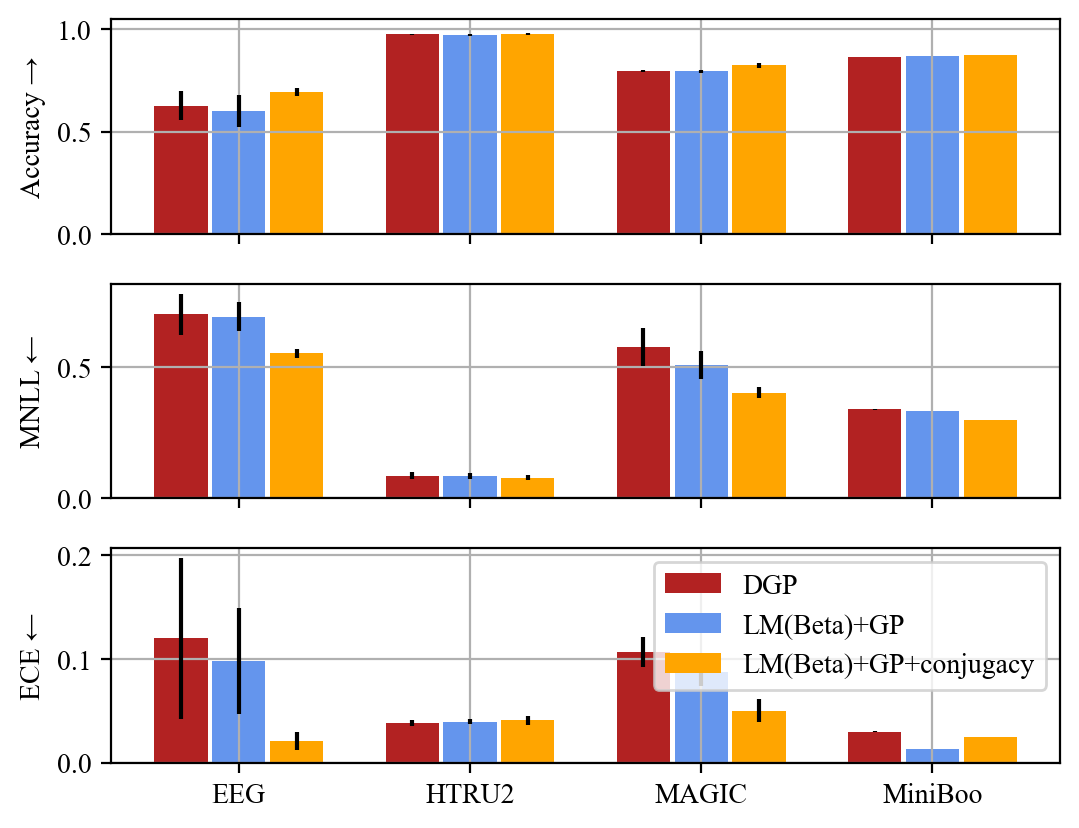

In [10]:
# plot the results
w=0.23
c=0.25
x=np.arange(4)

fig, ax = plt.subplots(3, 1, figsize=(figwidth, 2.5*figheight), dpi=200, sharex=True)

ax[0].bar(x-1*c, DGP_acc_mean, width=w, yerr=2*DGP_acc_std, color="firebrick", label="DGP")
ax[0].bar(x, LMGP_acc_mean, width=w, yerr=2*LMGP_acc_std, color="cornflowerblue", label="LM(Beta)+GP")
ax[0].bar(x+1*c, LMGP_con_acc_mean, width=w, yerr=2*LMGP_con_acc_std, color="orange", label="LM(Beta)+GP+conjugacy")
ax[0].grid()
ax[0].set_ylim(0, 1.05)
ax[0].set_ylabel(u"Accuracy \u2192")
#ax[0].legend()

ax[1].bar(x-1*c, DGP_mnll_mean, width=w, yerr=2*DGP_mnll_std, color="firebrick", label="DGP")
ax[1].bar(x, LMGP_mnll_mean, width=w, yerr=2*LMGP_mnll_std, color="cornflowerblue", label="LM(Beta)+GP")
ax[1].bar(x+1*c, LMGP_con_mnll_mean, width=w, yerr=2*LMGP_con_mnll_std, color="orange", label="LM(Beta)+GP+conjugacy")
ax[1].grid()
ax[1].set_ylabel(u"MNLL \u2190")

ax[2].bar(x-1*c, DGP_ece_mean, width=w, yerr=2*DGP_ece_std, color="firebrick", label="DGP")
ax[2].bar(x, LMGP_ece_mean, width=w, yerr=2*LMGP_ece_std, color="cornflowerblue", label="LM(Beta)+GP")
ax[2].bar(x+1*c, LMGP_con_ece_mean, width=w, yerr=2*LMGP_con_ece_std, color="orange", label="LM(Beta)+GP+conjugacy")
ax[2].grid()
ax[2].set_ylabel(u"ECE \u2190")
ax[2].legend()

ax[2].set_xticks(x)
ax[2].set_xticklabels(["EEG", "HTRU2", "MAGIC", "MiniBoo"])

plt.tight_layout()
plt.savefig("figures/bin_class_results.pdf")
plt.show();